In [133]:
from google.colab import drive
drive.mount('/content/drive')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils.parallel import Parallel, delayed
import xgboost as xgb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings


warnings.filterwarnings("ignore")

## Load Data

In [3]:
# path to the .txt file containing transaction data - JSON format
file_path = '/content/drive/MyDrive/CapitalOne/transactions.txt'

In [4]:
df = pd.read_json(file_path, lines=True)

In [5]:
df.shape

(786363, 29)

In [6]:
pd.set_option('display.max_columns', None)
df.sample(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
302507,132924394,132924394,15000,12331.10,2016-12-21T08:03:50,115.24,Auntie Anne's #864854,US,US,09,01,fastfood,08/2026,2015-09-29,2015-09-29,629,629,6421,PURCHASE,,2668.90,,,,True,,,False,False
724318,406723870,406723870,7500,4550.40,2016-12-01T16:29:01,85.08,Ray's Fries #24425,US,US,09,01,food,08/2025,2015-04-09,2016-11-20,235,235,2112,REVERSAL,,2949.60,,,,True,,,False,False
625037,406937949,406937949,20000,13470.03,2016-09-06T09:59:30,65.80,ebay.com,US,US,09,01,online_retail,07/2028,2015-02-14,2016-07-12,907,907,1908,PURCHASE,,6529.97,,,,False,,,False,False
360746,832842201,832842201,15000,3173.02,2016-01-29T17:12:09,58.04,Uber,US,US,05,01,rideshare,07/2021,2015-02-21,2015-02-21,213,213,760,PURCHASE,,11826.98,,,,False,,,False,False
576999,325238633,325238633,15000,14576.74,2016-10-17T12:27:54,17.32,In-N-Out #948343,US,US,05,01,fastfood,05/2032,2014-01-13,2014-01-13,714,714,4926,PURCHASE,,423.26,,,,True,,,False,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [8]:
df.isna().sum(axis=0)

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [9]:
# some columns have empty strings - confirmation
print("echoBuffer value counts: ", df['echoBuffer'].value_counts())
print("merchantCity value counts: ", df['merchantCity'].value_counts())
print("merchantState value counts: ", df['merchantState'].value_counts())
print("merchantZip value counts: ", df['merchantZip'].value_counts())
print("posOnPremises value counts: ", df['posOnPremises'].value_counts())
print("recurringAuthInd value counts: ", df['recurringAuthInd'].value_counts())



echoBuffer value counts:  echoBuffer
    786363
Name: count, dtype: int64
merchantCity value counts:  merchantCity
    786363
Name: count, dtype: int64
merchantState value counts:  merchantState
    786363
Name: count, dtype: int64
merchantZip value counts:  merchantZip
    786363
Name: count, dtype: int64
posOnPremises value counts:  posOnPremises
    786363
Name: count, dtype: int64
recurringAuthInd value counts:  recurringAuthInd
    786363
Name: count, dtype: int64


In [10]:
# convert these columns into NaN values
df.replace("", np.nan, inplace=True)

In [11]:
df.isna().sum(axis=0)

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [12]:
df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,0.0,786363.000000,0.0,0.0,0.0,0.0,0.0
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,NaN,689.910000,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


In [13]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       4
merchantCountryCode              4
posEntryMode                     5
posConditionCode                 3
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  3
echoBuffer                       0
currentBalance              487318
merchantCity                     0
merchantState                    0
merchantZip                      0
cardPresent                      2
posOnPremises                    0
recurringAuthInd                 0
expirationDateKeyInMatch         2
isFraud             

In [14]:
df['isFraud'].value_counts()

isFraud
False    773946
True      12417
Name: count, dtype: int64

In [15]:
df['posEntryMode'].value_counts()

posEntryMode
05    315035
09    236481
02    195934
90     19576
80     15283
Name: count, dtype: int64

In [16]:
df['posConditionCode'].value_counts()

posConditionCode
01    628787
08    149634
99      7533
Name: count, dtype: int64

In [17]:
df['transactionType'].value_counts()

transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: count, dtype: int64

In [18]:
# transaction-type for fraud/non-fraud cases
counts = df.groupby('isFraud')['transactionType'].value_counts().unstack()
# Normalize the counts to get the percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages

transactionType,ADDRESS_VERIFICATION,PURCHASE,REVERSAL
isFraud,,,
False,2.593300,94.824652,2.582049
True,0.935258,96.347658,2.717085


### ADDRESS_VERIFICATION transactionType is less likely to be a fraud transaction

In [19]:
# merchant category code for fraud/non-fraud cases
counts = df.groupby('isFraud')['merchantCategoryCode'].value_counts().unstack()
# Normalize the counts to get the percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages

merchantCategoryCode,airline,auto,cable/phone,entertainment,fastfood,food,food_delivery,fuel,furniture,gym,health,hotels,mobileapps,online_gifts,online_retail,online_subscriptions,personal care,rideshare,subscriptions
isFraud,,,,,,,,,,,,,,,,,,,
False,1.922356,2.762208,0.178565,10.225132,14.350355,9.622894,0.775248,3.089363,0.946965,0.28542,2.455210,4.373303,1.936828,8.350970,25.48214,1.429945,2.439188,6.442827,2.931083
True,4.300556,2.198599,NaN,7.739390,8.649432,8.166224,NaN,NaN,0.829508,NaN,0.724813,2.013369,NaN,12.933881,39.76806,NaN,0.692599,10.244020,1.739551


#### online_retail merchantCategoryCode is more likely to be a fraud transaction

In [20]:
# acqCountry code for fraud/non-fraud cases
counts = df.groupby('isFraud')['acqCountry'].value_counts().unstack()
# Normalize the counts to get the percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages

acqCountry,CAN,MEX,PR,US
isFraud,,,,
False,0.307849,0.398423,0.196353,99.097375
True,0.448321,0.521682,0.220085,98.809912


In [21]:
# merchantCountryCode for fraud/non-fraud cases
counts = df.groupby('isFraud')['merchantCountryCode'].value_counts().unstack()
# Normalize the counts to get the percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages

merchantCountryCode,CAN,MEX,PR,US
isFraud,,,,
False,0.306477,0.398162,0.198111,99.097250
True,0.453993,0.518849,0.218889,98.808269


In [22]:
df['accountNumber'].nunique()

5000

#### 5000 unique accounts

## Plot

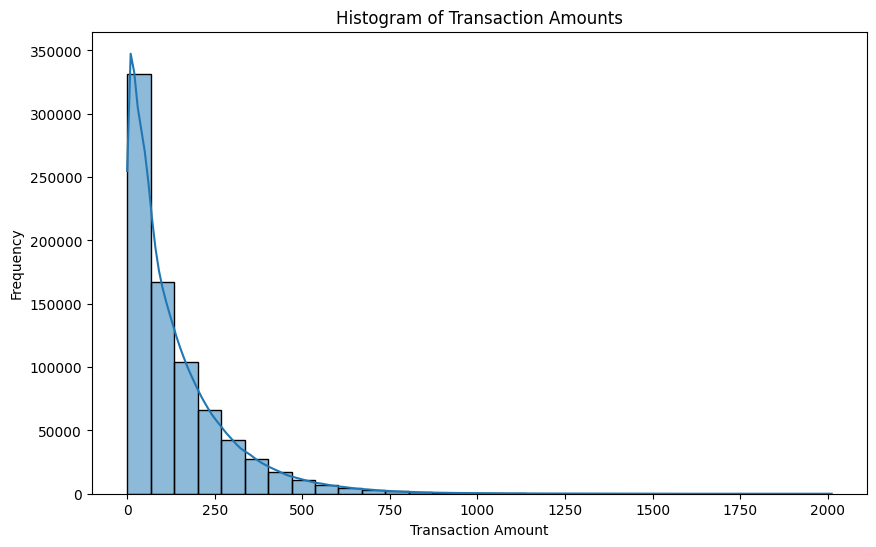

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['transactionAmount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

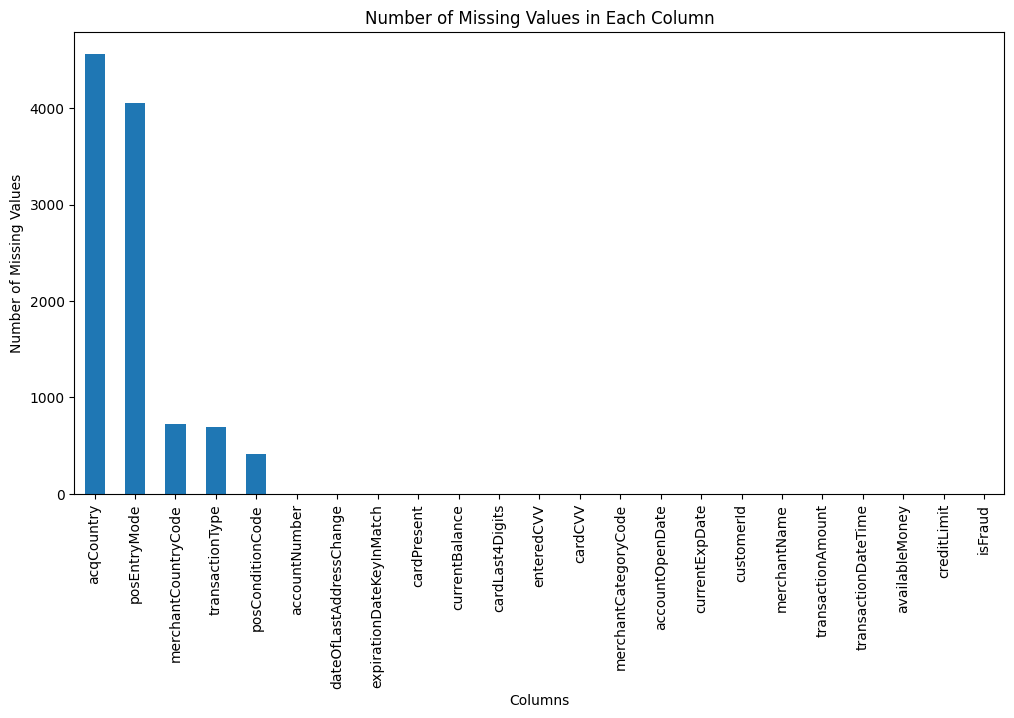

In [24]:
# remove empty columns and then plot the missing values for each column to visualize better
df_missing = df.drop(columns= ['echoBuffer','merchantCity','merchantState','merchantZip',
                                                   'posOnPremises','recurringAuthInd'])
missing_values = df_missing.isna().sum().sort_values(ascending=False)

# Plot the number of missing values
plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar')
plt.title('Number of Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

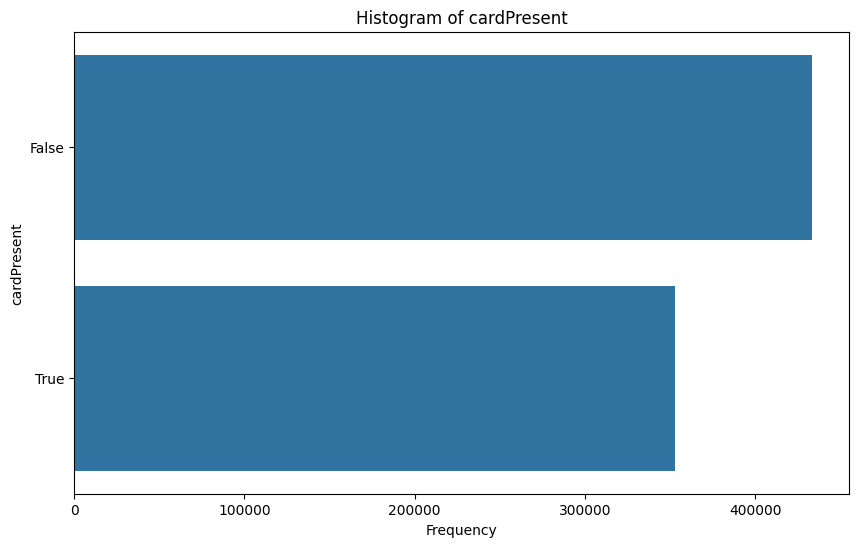

In [25]:

# visualize cardPresent
plt.figure(figsize=(10, 6))
sns.barplot(df['cardPresent'].value_counts().head(20), orient = 'h')
plt.title('Histogram of cardPresent')
plt.xlabel('Frequency')
plt.ylabel('cardPresent')
plt.show()

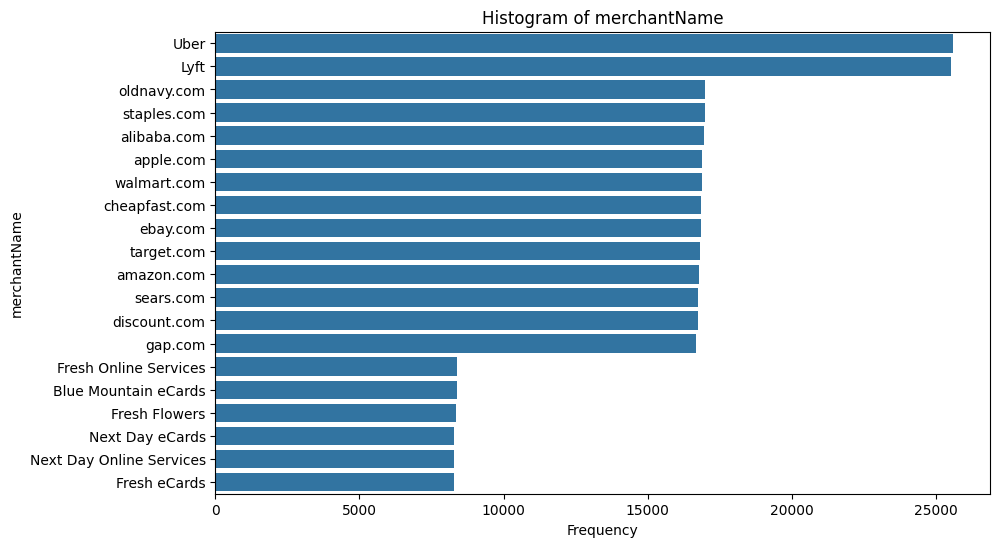

In [26]:
# visualize merchantName
plt.figure(figsize=(10, 6))
sns.barplot(df['merchantName'].value_counts().head(20), orient = 'h')
plt.title('Histogram of merchantName')
plt.xlabel('Frequency')
plt.ylabel('merchantName')
plt.show()

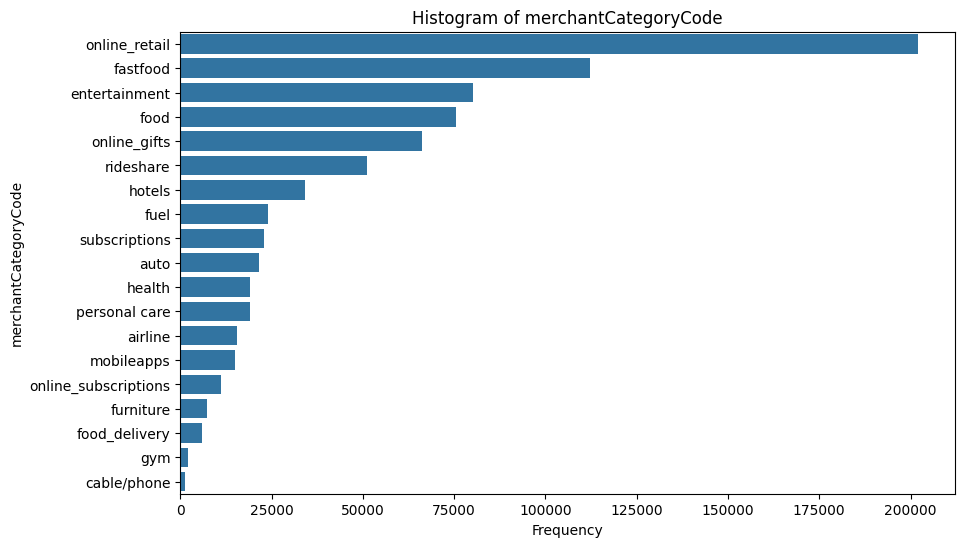

In [27]:
# visualize merchantCategoryCode
plt.figure(figsize=(10, 6))
sns.barplot(df['merchantCategoryCode'].value_counts().head(20), orient = 'h')
plt.title('Histogram of merchantCategoryCode')
plt.xlabel('Frequency')
plt.ylabel('merchantCategoryCode')
plt.show()

<Figure size 1500x1000 with 0 Axes>

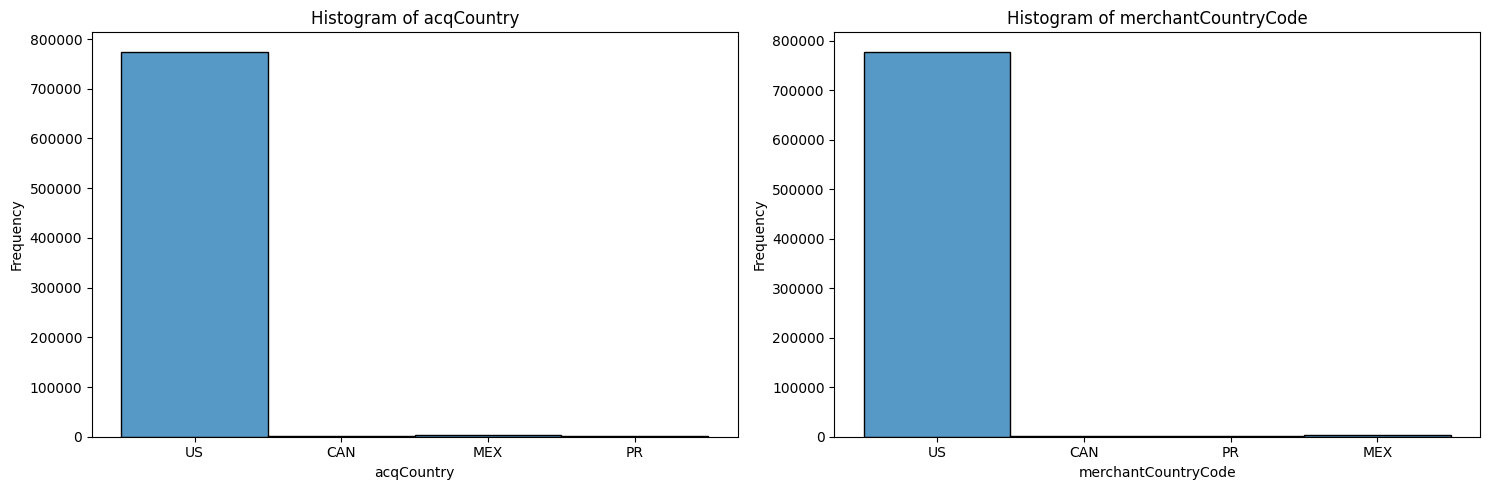

In [28]:
# visualize acqCountry & merchantCountryCode
country_columns = ['acqCountry', 'merchantCountryCode']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

# Plot a histogram for each country_column
for i, column in enumerate(country_columns):
    sns.histplot(df[column].dropna(), bins=30, ax=axs[i])
    axs[i].set_title(f'Histogram of {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

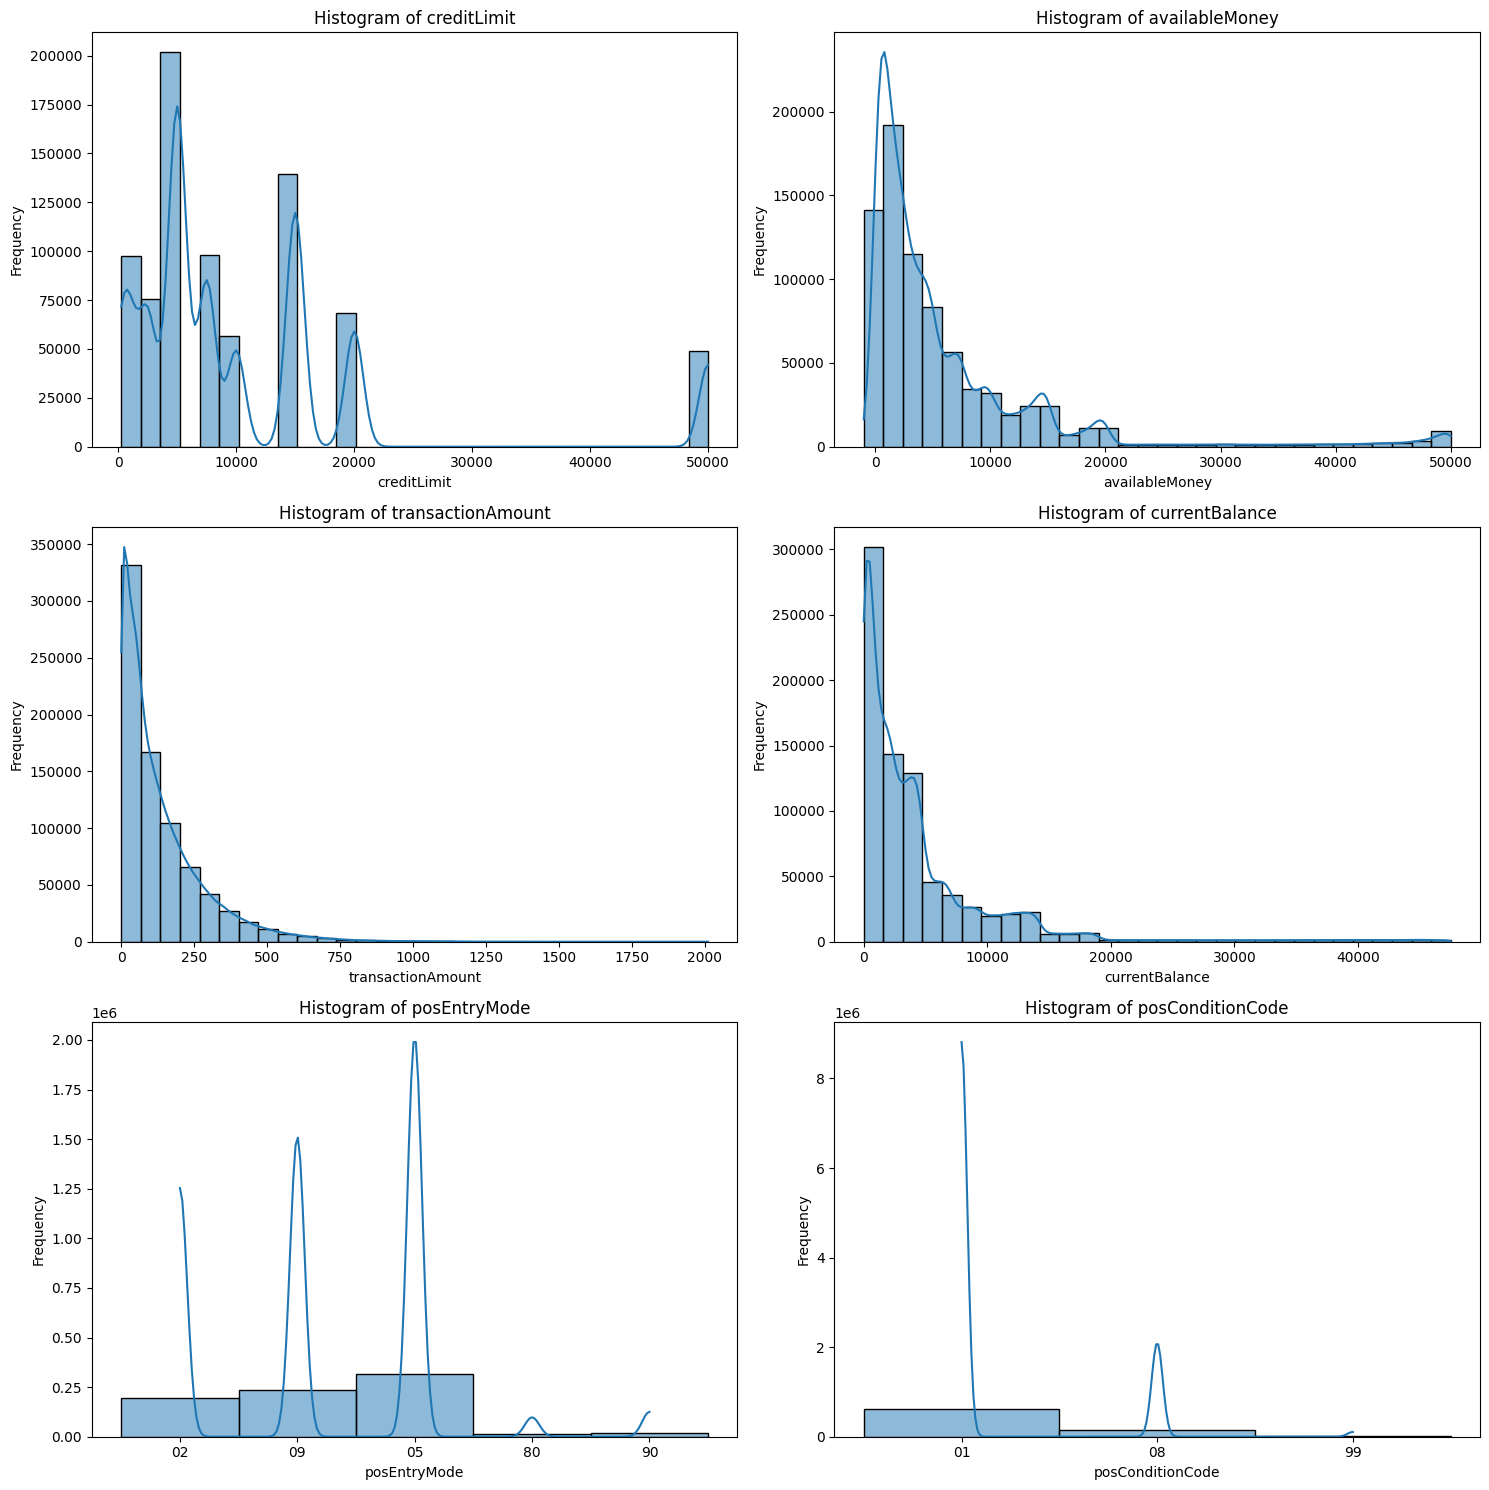

In [29]:
# visualize numerical fields with histograms
# Identify numerical columns
numerical_columns = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'posEntryMode', 'posConditionCode']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

# Plot a histogram for each numerical column
for i, column in enumerate(numerical_columns):
    sns.histplot(df[column].dropna(), bins=30, kde=True, ax=axs[i])
    axs[i].set_title(f'Histogram of {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Observations:

- creditLimit - most of the credit card holders have their credit limit less than 20k
- availableMoney - most of the credit card holders have less than 10k available balance
- transactionAmount - people usually use credit cards for small purchases ~500
- currentBalance - most of the credit card holders have less than 10k balance currently
- posEntryMode - which is the two-digit code identifies the actual method used to enter the cardholder account number and card expiration date -- mostly used methods are: 05 (Integrated circuit/chip card read), 09 (PAN entry via electronic commerce, including chip.), 02 (Magnetic stripe) \
(Ref: https://developer.network.ae/docs/read/upf/appendix/POS_Entry_Mode)
- posConditionCode - which is a code identifying transaction conditions at the point-of-sale or point-of-service -- mostly used: 01 (
Cardholder not present) \
(Ref: https://www.mreports.com/documentation/ac/nonmerchant/80449.htm)

In [30]:
df[df['cardCVV']!=df['enteredCVV']]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
19,574788567,574788567,2500,2304.46,2016-01-29T07:33:15,196.07,Shell Auto Body,US,US,09,01,auto,08/2022,2015-10-13,2015-10-13,579,539,4219,PURCHASE,NaN,195.54,NaN,NaN,NaN,True,NaN,NaN,False,False
100,924729945,924729945,50000,50000.00,2016-10-04T04:20:04,168.57,discount.com,US,US,05,01,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
101,924729945,924729945,50000,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,01,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,REVERSAL,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False
211,984504651,984504651,50000,35211.58,2016-02-16T18:41:33,296.68,WSC #467811,US,US,05,01,health,02/2032,2015-07-27,2015-07-27,640,670,8332,PURCHASE,NaN,14788.42,NaN,NaN,NaN,False,NaN,NaN,False,False
261,984504651,984504651,50000,27469.74,2016-03-12T00:26:54,670.23,Walgreens #853025,US,US,09,01,health,02/2030,2015-07-27,2015-07-27,640,240,8332,PURCHASE,NaN,22530.26,NaN,NaN,NaN,False,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786154,638498773,638498773,10000,2911.57,2016-05-19T05:11:33,59.52,Pizza Hut #213060,US,US,05,08,fastfood,05/2031,2014-11-17,2014-11-17,387,382,4635,PURCHASE,NaN,7088.43,NaN,NaN,NaN,True,NaN,NaN,False,False
786194,638498773,638498773,10000,3761.24,2016-08-22T17:35:15,177.89,Burger King #252057,US,US,05,01,fastfood,11/2023,2014-11-17,2014-11-17,387,382,4635,PURCHASE,NaN,6238.76,NaN,NaN,NaN,True,NaN,NaN,False,False
786228,638498773,638498773,10000,4153.23,2016-11-15T17:56:05,45.56,Popeyes #179461,US,US,09,08,fastfood,04/2027,2014-11-17,2014-11-17,175,783,321,PURCHASE,NaN,5846.77,NaN,NaN,NaN,True,NaN,NaN,False,False
786265,732852505,732852505,50000,49688.67,2016-02-16T23:02:52,0.00,Lyft,US,US,05,01,rideshare,08/2022,2012-08-23,2012-08-23,936,536,3783,ADDRESS_VERIFICATION,NaN,311.33,NaN,NaN,NaN,False,NaN,NaN,False,False


## Interesting to see that there are few examples where the entered cvv doesn't match the cardcvv but the transaction is still marked as non-fraudulent
when read more about this, there are actually few scenarios where there can be a legit non-matching cvv transaction such as
- recurring payments where once the initial setup is done, it doesn't require cvv
- if acc to the historical data like users' spending pattern, location, verified merchantName matches, it gets approved
etc

In [31]:
df.dtypes

accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                  float64
currentBalance              float64
merchantCity                float64
merchantState               float64
merchantZip                 float64
cardPresent                    bool
posOnPremises               float64
recurringAuthInd            float64
expirationDateKeyInMatch    

## Data Wrangling - Duplicate Transactions

### 1. Reversed transaction

> where a purchase is followed by a reversal


In [32]:
df['transactionType'].value_counts()

transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: count, dtype: int64

In [34]:
reversed_transactions_df = df[df['transactionType']=='REVERSAL']
print('Total number of transactions estimated for the reversed transactions: ', len(reversed_transactions_df))
print('Total dollar amount estimated for the reversed transactions: ', reversed_transactions_df['transactionAmount'].sum())

Total number of transactions estimated for the reversed transactions:  20303
Total dollar amount estimated for the reversed transactions:  2821792.5


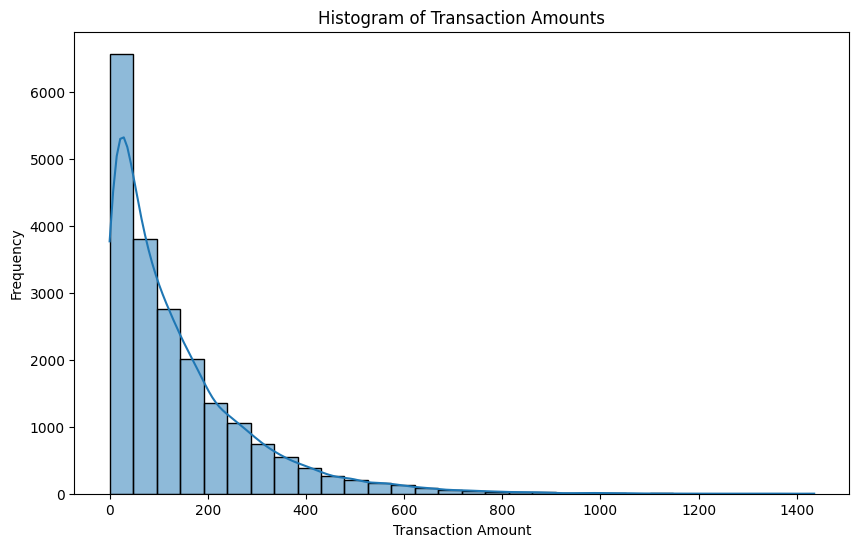

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(reversed_transactions_df['transactionAmount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

### 2. Multi-swipe transactions

> where a vendor accidentally charges a customer's card multiple times within a short time span.

In [36]:
# verifying if the account number and customer id is unique to each customer
df[df['accountNumber']!=df['customerId']]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud


In [37]:
# visualize cases for multi-swipe transactions
df = df.sort_values(by=['accountNumber',  'merchantName', 'transactionAmount', 'transactionDateTime'], ascending=True)

> Note: i am making changes to the original DF beccause isMultiSwipe (column created later) will be a feature that would come handy when making the predictive model for fraud detection


In [38]:
df[45:60][['accountNumber', 'merchantName', 'transactionDateTime', 'transactionAmount']]

,accountNumber,merchantName,transactionDateTime,transactionAmount
541955,100088067,Fresh Flowers,2016-10-16T18:01:00,411.35
541956,100088067,Fresh Flowers,2016-10-16T18:01:02,411.35
541916,100088067,Fresh Online Services,2016-04-01T04:47:33,46.19
541930,100088067,Fresh eCards,2016-07-06T10:09:16,43.86
541915,100088067,Fresh eCards,2016-03-25T21:32:36,161.45
541966,100088067,Fresh eCards,2016-11-23T07:57:10,187.18
541910,100088067,John's Bistro,2016-02-25T21:57:26,161.99
541959,100088067,Mobile eCards,2016-11-05T03:55:37,6.32
541969,100088067,Mobile eCards,2016-12-16T17:56:10,8.95
541902,100088067,Mobile eCards,2016-01-17T15:41:46,378.67


## here, transaction with index 541955 and 541956 can be considered as multi-swipe transaction

In [39]:
# Convert transactionDateTime to datetime
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [40]:
df.shape

(786363, 29)

In [41]:
df['timeDiff'] = df.groupby(['merchantName', 'accountNumber', 'transactionAmount'])['transactionDateTime'].diff()

In [42]:
df.shape

(786363, 30)

In [43]:
df[df['timeDiff'].isna()==False][:20]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,timeDiff
541964,100088067,100088067,50000,49811.88,2016-11-20 08:00:04,22.32,AMC #79863,US,US,09,01,entertainment,06/2020,2014-01-09,2014-01-09,546,546,4615,REVERSAL,NaN,188.12,NaN,NaN,NaN,True,NaN,NaN,False,False,0 days 00:02:59
541926,100088067,100088067,50000,49695.85,2016-06-05 22:10:41,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,304.15,NaN,NaN,NaN,False,NaN,NaN,False,False,30 days 23:22:51
541929,100088067,100088067,50000,50000.00,2016-07-05 22:22:49,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False,30 days 00:12:08
541936,100088067,100088067,50000,50000.00,2016-08-05 00:55:48,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False,30 days 02:32:59
541945,100088067,100088067,50000,49867.31,2016-09-05 13:14:22,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,132.69,NaN,NaN,NaN,False,NaN,NaN,False,False,31 days 12:18:34
541952,100088067,100088067,50000,50000.00,2016-10-05 19:41:40,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False,30 days 06:27:18
541960,100088067,100088067,50000,49993.68,2016-11-06 10:49:52,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,6.32,NaN,NaN,NaN,False,NaN,NaN,False,False,31 days 15:08:12
541968,100088067,100088067,50000,49939.59,2016-12-07 07:48:20,3.96,Apple iTunes,US,US,09,01,mobileapps,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,60.41,NaN,NaN,NaN,False,NaN,NaN,False,False,30 days 20:58:28
541956,100088067,100088067,50000,49275.09,2016-10-16 18:01:02,411.35,Fresh Flowers,US,US,02,08,online_gifts,12/2019,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,724.91,NaN,NaN,NaN,False,NaN,NaN,False,False,0 days 00:00:02
541957,100088067,100088067,50000,48863.74,2016-10-24 12:07:21,60.41,Shell Gas #256420,US,US,05,01,fuel,03/2028,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,1136.26,NaN,NaN,NaN,True,NaN,NaN,False,False,14 days 06:11:23


In [44]:
# Create the isMultiSwipe column based on the time_diff - multi-swipe considered if time diff < 2 min
df['isMultiSwipe'] = df['timeDiff'].dt.total_seconds().lt(120)

In [45]:
# Fill NaN values with False (first transaction in each group)
df['isMultiSwipe'] = df['isMultiSwipe'].fillna(False)

In [46]:
df.shape

(786363, 31)

In [47]:
multi_swipe_trans_df = df[df['isMultiSwipe']==True]

## `multi_swipe_trans_df` is a multi-swipe transactions dataframe

In [48]:
print('Total number of transactions estimated for the multi-swipe transactions: ', len(multi_swipe_trans_df))
print('Total dollar amount estimated for the multi-swipe transactions: ', multi_swipe_trans_df['transactionAmount'].sum())

Total number of transactions estimated for the multi-swipe transactions:  8879
Total dollar amount estimated for the multi-swipe transactions:  1304345.4100000001


In [49]:
df['isMultiSwipe'].value_counts()

isMultiSwipe
False    777484
True       8879
Name: count, dtype: int64

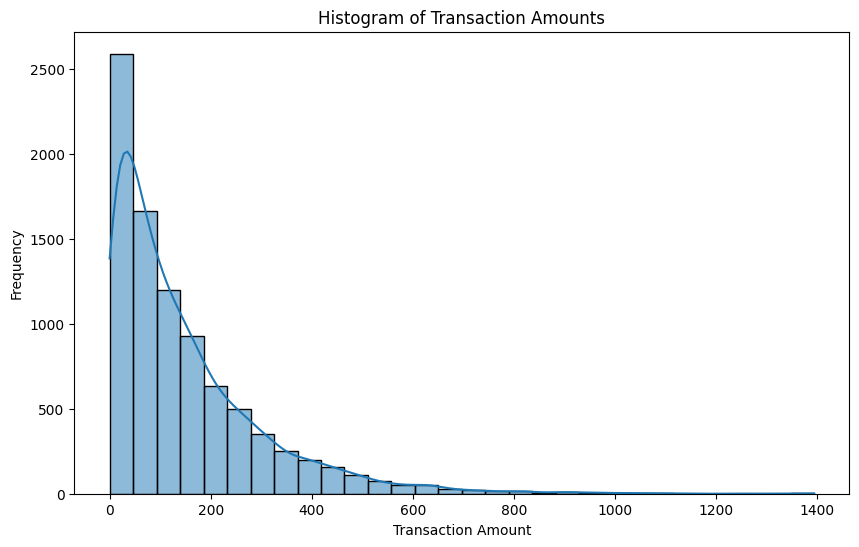

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(multi_swipe_trans_df['transactionAmount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

## Interesting facts
- there are some transactions with same account number, merchantName, transactionAmount with more than 2 min and less than 4 min time diff which has not been considered. On reading more upon it, bank notifies the user depending upon the transaction history which can be another use case for some rule-based/ML system to predict if the transaction is valid or not.

# Model

In [51]:
df.shape

(786363, 31)

In [52]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud', 'timeDiff',
       'isMultiSwipe'],
      dtype='object')

### Handling missing values

In [53]:
df.isna().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

### We've already discovered that these columns are empty and hence do not contribute to the isFraud attribute prediction, hence we'll drop them
`[echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd, timeDiff]`

In [54]:
columns_to_drop = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd', 'timeDiff']
df.drop(columns=columns_to_drop, inplace=True)

In [55]:
df.isna().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
isMultiSwipe                   0
dtype: int64

In [56]:
# visualize few examples with missing values affecting isFraud attribute
df[((df['acqCountry'].isna()==True) | (df['merchantCountryCode'].isna()==True) | \
 (df['posEntryMode'].isna()==True) | (df['posConditionCode'].isna()==True) | (df['transactionType'].isna()==True))  & (df['isFraud']==True)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,isMultiSwipe
541973,100088067,100088067,50000,49734.57,2016-12-26 19:14:46,309.96,South Cafe,US,US,NaN,01,food,11/2021,2014-01-09,2014-01-09,546,546,4615,PURCHASE,265.43,True,False,True,False
474220,101376441,101376441,7500,7500.00,2016-02-06 07:42:04,99.79,alibaba.com,US,US,NaN,01,online_retail,09/2029,2015-06-08,2015-06-08,128,128,6683,PURCHASE,0.00,False,False,True,False
690105,102755773,102755773,2500,763.48,2016-04-26 01:47:19,99.55,staples.com,US,US,NaN,99,online_retail,02/2025,2010-06-28,2010-06-28,875,875,2415,PURCHASE,1736.52,False,False,True,False
403152,105730883,105730883,500,101.75,2016-11-25 12:20:15,23.43,ebay.com,US,US,NaN,08,online_retail,11/2032,2013-10-20,2016-05-19,961,961,1397,PURCHASE,398.25,False,False,True,False
126366,108011952,108011952,5000,4588.22,2016-01-14 11:10:36,166.53,amazon.com,NaN,NaN,09,01,online_retail,08/2028,2015-03-29,2015-03-29,336,336,5045,PURCHASE,411.78,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668058,983090780,983090780,250,61.14,2016-01-22 04:05:03,380.54,discount.com,NaN,NaN,02,01,online_retail,02/2027,2015-08-10,2015-08-10,496,496,2876,PURCHASE,188.86,False,False,True,False
708134,984146652,984146652,15000,11987.86,2016-11-30 11:55:47,121.01,Shake Shack #444315,US,US,NaN,01,fastfood,02/2033,2015-08-01,2016-02-28,980,980,1054,PURCHASE,3012.14,True,False,True,False
17878,989091504,989091504,1000,943.78,2016-01-25 17:45:32,130.97,ashleyfurniture.com,US,US,NaN,01,furniture,03/2028,2013-03-01,2013-03-01,280,280,5282,PURCHASE,56.22,True,False,True,False
6809,996362843,996362843,1000,308.06,2016-04-08 14:13:19,17.35,walmart.com,US,US,NaN,01,online_retail,04/2031,2012-10-14,2016-04-02,367,367,4949,PURCHASE,691.94,False,False,True,False


In [57]:
# replace posEntryMode and posConditionCode missing values with 0
df['posEntryMode'] = df['posEntryMode'].fillna('0')
df['posConditionCode'] = df['posConditionCode'].fillna('0')

In [58]:
# replace transactionType missing values with 'missingType'
df['transactionType'] = df['transactionType'].fillna('missingType')

In [59]:
df.isna().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                   0
posConditionCode               0
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType                0
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
isMultiSwipe                   0
dtype: int64

In [60]:
df['merchantCategoryCode'].value_counts()

merchantCategoryCode
online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: count, dtype: int64

In [61]:
# as already discussed above, we'll make sense of cardCVV and enteredCVV attributes by checking whether they match or not
df['isCVVMatch'] = df['cardCVV'] == df['enteredCVV']

In [62]:
# remove columns not required anymore
columns_to_drop = ['customerId', 'acqCountry', 'merchantCountryCode', 'cardLast4Digits', 'merchantName', 'cardCVV', 'enteredCVV']
df.drop(columns=columns_to_drop, inplace=True)

### Outlier Detection (if any)

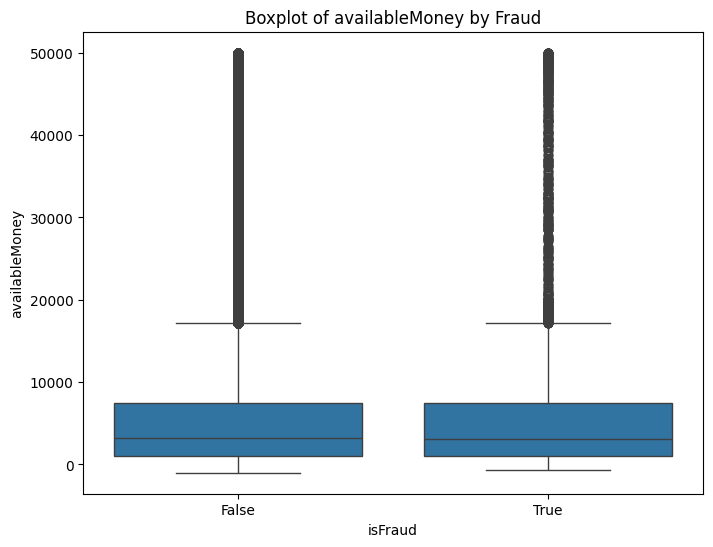

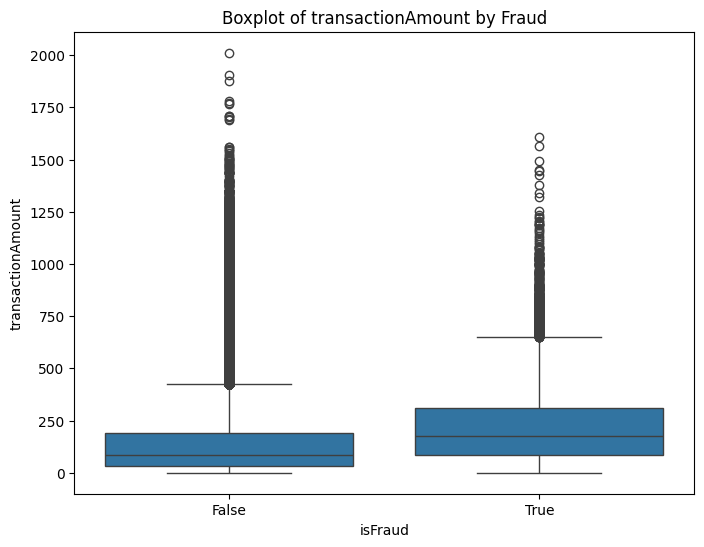

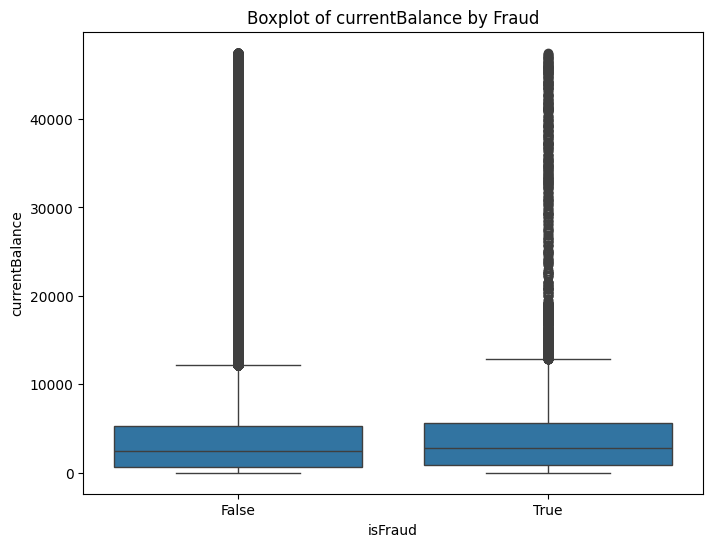

In [63]:
# Boxplots for outlier detection
num_features = ['availableMoney', 'transactionAmount', 'currentBalance']
for feature in num_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='isFraud', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Fraud')
    plt.show()

#### It is seen that transactionAmount has outliers beyond ~$1600 so we'll remove those examples and check

In [64]:
df = df[df['transactionAmount'] < 1600]

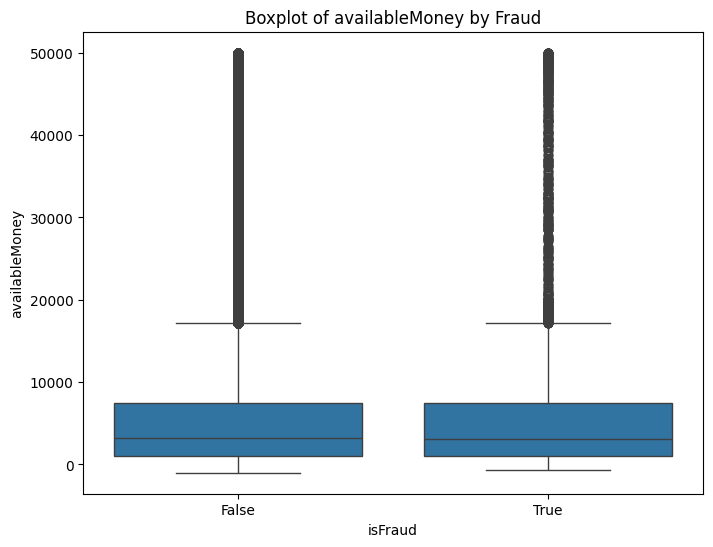

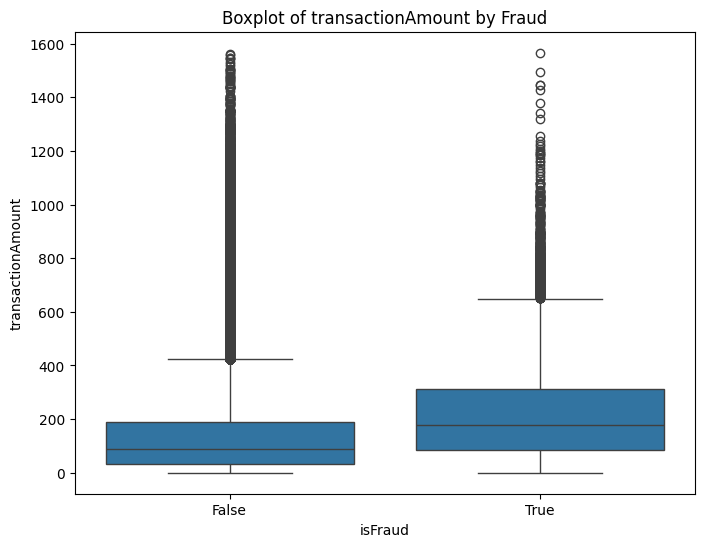

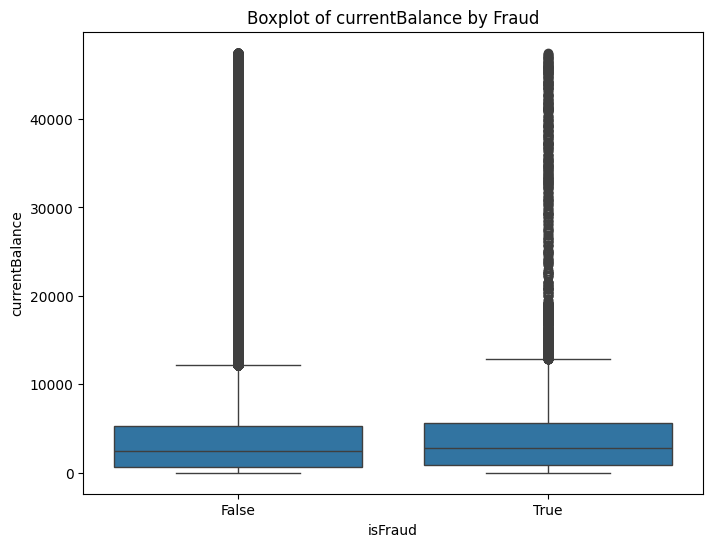

In [65]:
# Boxplots for outlier detection
num_features = ['availableMoney', 'transactionAmount', 'currentBalance']
for feature in num_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='isFraud', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Fraud')
    plt.show()

In [66]:
df.shape

(786351, 18)

### Extract features from datetime columns like - transactionDateTime, currentExpDate, accountOpenDate, dateOfLastAddressChange

In [67]:
# Convert to datetime
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'])

# Extract features
df['transactionHour'] = df['transactionDateTime'].dt.hour
df['transactionDayOfWeek'] = df['transactionDateTime'].dt.dayofweek
df['transactionDay'] = df['transactionDateTime'].dt.day
df['transactionMonth'] = df['transactionDateTime'].dt.month
df['transactionYear'] = df['transactionDateTime'].dt.year
df['transactionIsWeekend'] = df['transactionDateTime'].dt.dayofweek >= 5
df['transactionQuarter'] = df['transactionDateTime'].dt.quarter
df['elapsedTimeSinceAccountOpen'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['elapsedTimeSinceLastAddressChange'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['daysLeftToExpire'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days

#### remove columns not needed anymore

In [68]:
columns_to_drop = ['accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate', 'transactionDateTime']
df.drop(columns=columns_to_drop, inplace=True)

### Convert categorical columns to numerical features - merchantCategoryCode, transactionType

In [69]:
# One-hot encode specific columns
columns_to_encode = ['transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode)

In [70]:
# convert posEntryMode & posConditionCode into integers
df['posEntryMode'] = df['posEntryMode'].astype(int)
df['posConditionCode'] = df['posConditionCode'].astype(int)

In [71]:
# remove columns not required anymore
columns_to_drop = ['transactionType_missingType']
df.drop(columns=columns_to_drop, inplace=True)

In [72]:
df

,accountNumber,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,isMultiSwipe,isCVVMatch,transactionHour,transactionDayOfWeek,transactionDay,transactionMonth,transactionYear,transactionIsWeekend,transactionQuarter,elapsedTimeSinceAccountOpen,elapsedTimeSinceLastAddressChange,daysLeftToExpire,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions
541917,100088067,50000,49953.81,200.12,9,1,46.19,True,False,False,False,True,19,4,8,4,2016,False,2,820,820,4831,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
541962,100088067,50000,49929.31,95.11,2,1,70.69,True,False,False,False,True,7,2,9,11,2016,False,4,1035,1035,1603,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
541920,100088067,50000,49996.04,5.26,2,1,3.96,True,False,False,False,True,2,4,6,5,2016,False,2,848,848,6264,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
541904,100088067,50000,49933.93,141.60,9,8,66.07,True,False,False,False,True,4,2,3,2,2016,False,1,755,755,5384,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
541925,100088067,50000,50000.00,304.15,2,1,0.00,True,False,False,False,True,18,4,3,6,2016,False,2,876,876,5994,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108113,999389635,5000,4674.08,4.62,5,1,325.92,False,False,False,False,True,16,6,23,10,2016,True,4,380,380,6003,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
108114,999389635,5000,4694.46,4.62,5,1,305.54,False,False,False,False,True,0,3,24,11,2016,False,4,412,412,5971,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
108115,999389635,5000,4714.84,4.62,5,1,285.16,False,False,False,False,True,5,5,24,12,2016,True,4,442,442,5941,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
108109,999389635,5000,4943.92,42.98,9,1,56.08,False,False,False,False,True,20,3,4,8,2016,False,3,300,300,2521,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [73]:
df.columns

Index(['accountNumber', 'creditLimit', 'availableMoney', 'transactionAmount',
       'posEntryMode', 'posConditionCode', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'isMultiSwipe', 'isCVVMatch',
       'transactionHour', 'transactionDayOfWeek', 'transactionDay',
       'transactionMonth', 'transactionYear', 'transactionIsWeekend',
       'transactionQuarter', 'elapsedTimeSinceAccountOpen',
       'elapsedTimeSinceLastAddressChange', 'daysLeftToExpire',
       'transactionType_ADDRESS_VERIFICATION', 'transactionType_PURCHASE',
       'transactionType_REVERSAL', 'merchantCategoryCode_airline',
       'merchantCategoryCode_auto', 'merchantCategoryCode_cable/phone',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
       'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
      

### convert Boolean values into binaries

In [74]:
boolean_columns = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'isMultiSwipe', 'isCVVMatch',
                   'transactionIsWeekend', 'transactionType_ADDRESS_VERIFICATION', 'transactionType_PURCHASE',
                    'transactionType_REVERSAL', 'merchantCategoryCode_airline',
                    'merchantCategoryCode_auto', 'merchantCategoryCode_cable/phone',
                    'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
                    'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
                    'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
                    'merchantCategoryCode_gym', 'merchantCategoryCode_health',
                    'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps',
                    'merchantCategoryCode_online_gifts',
                    'merchantCategoryCode_online_retail',
                    'merchantCategoryCode_online_subscriptions',
                    'merchantCategoryCode_personal care', 'merchantCategoryCode_rideshare',
                    'merchantCategoryCode_subscriptions']
df[boolean_columns] = df[boolean_columns].astype(int)

In [75]:
df.isna().sum()

accountNumber                                0
creditLimit                                  0
availableMoney                               0
transactionAmount                            0
posEntryMode                                 0
posConditionCode                             0
currentBalance                               0
cardPresent                                  0
expirationDateKeyInMatch                     0
isFraud                                      0
isMultiSwipe                                 0
isCVVMatch                                   0
transactionHour                              0
transactionDayOfWeek                         0
transactionDay                               0
transactionMonth                             0
transactionYear                              0
transactionIsWeekend                         0
transactionQuarter                           0
elapsedTimeSinceAccountOpen                  0
elapsedTimeSinceLastAddressChange            0
daysLeftToExp

In [76]:
df.shape

(786351, 44)

In [77]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Extract correlation of each feature with 'isFraud'
correlation_with_isFraud = correlation_matrix["isFraud"].sort_values(ascending=False)

In [78]:
correlation_with_isFraud

isFraud                                      1.000000
transactionAmount                            0.075644
merchantCategoryCode_online_retail           0.040736
merchantCategoryCode_airline                 0.021390
merchantCategoryCode_online_gifts            0.020574
merchantCategoryCode_rideshare               0.019221
transactionType_PURCHASE                     0.008383
posConditionCode                             0.008090
currentBalance                               0.007721
posEntryMode                                 0.006667
creditLimit                                  0.003113
daysLeftToExpire                             0.001780
transactionType_REVERSAL                     0.001057
isMultiSwipe                                 0.000754
transactionDay                              -0.000749
transactionHour                             -0.000877
expirationDateKeyInMatch                    -0.000972
transactionDayOfWeek                        -0.001281
merchantCategoryCode_furnitu

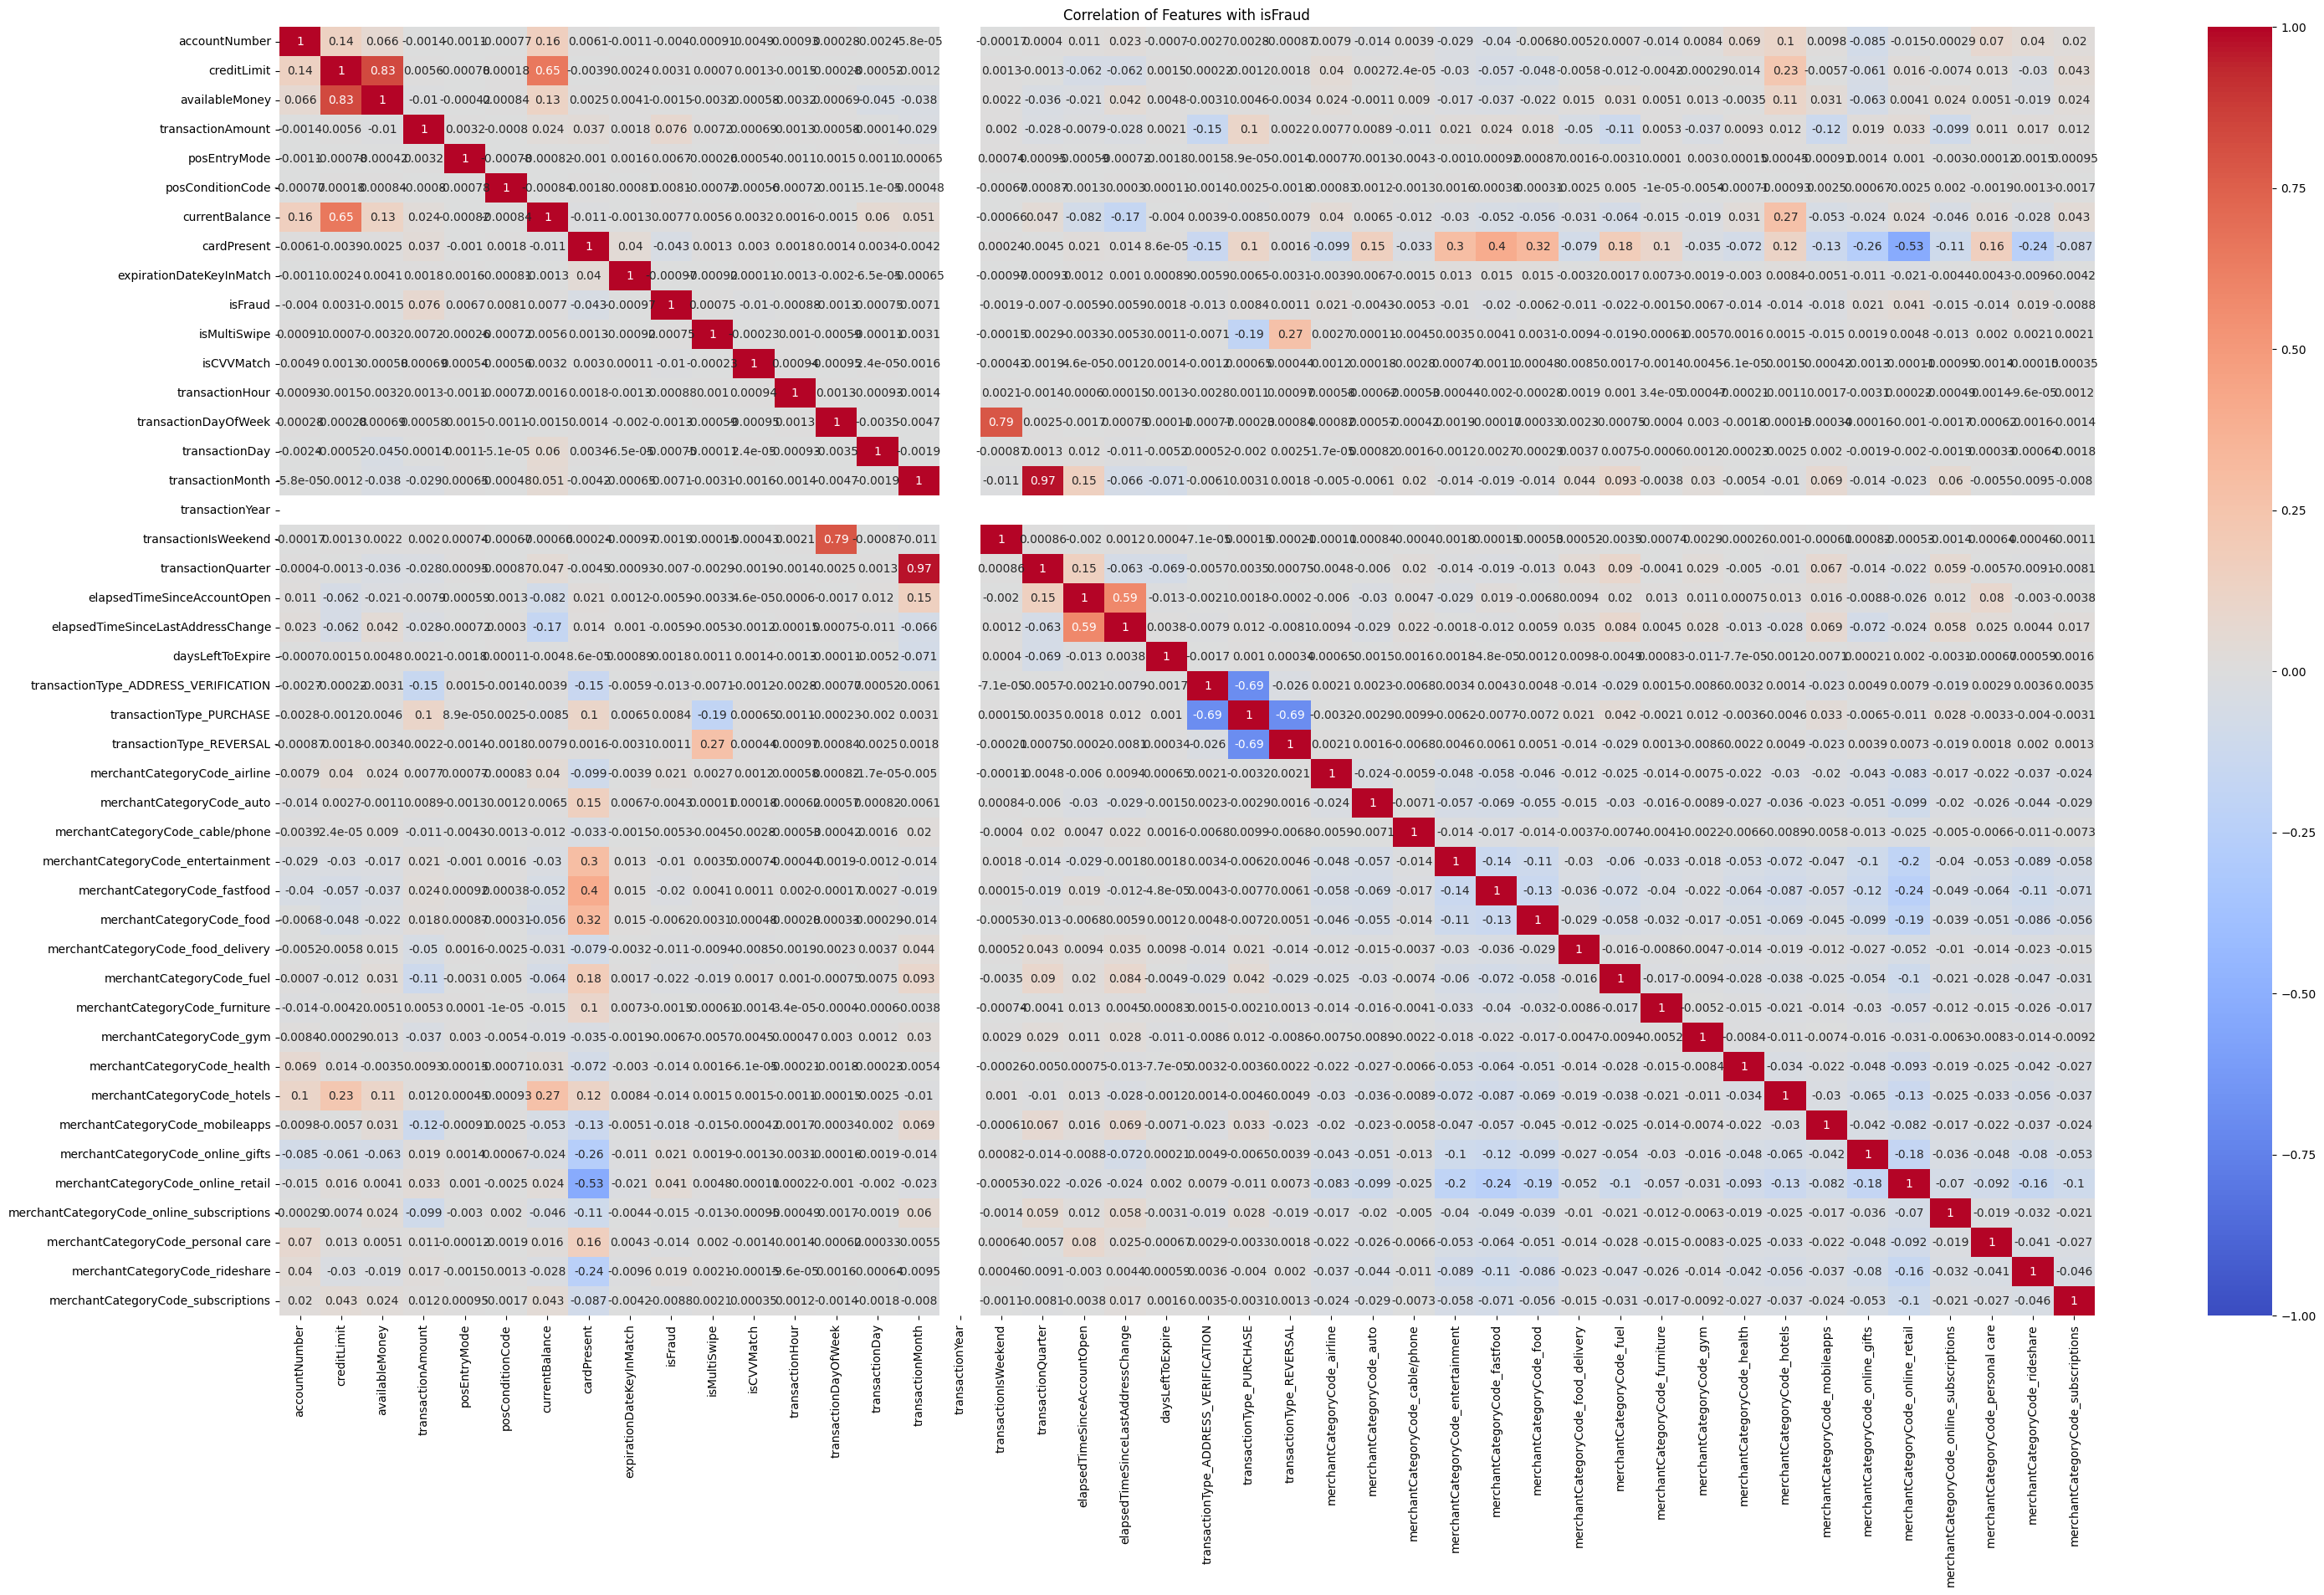

In [79]:
# Plot heatmap
plt.figure(figsize=(35, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with isFraud')
plt.show()

### Observations
- From the heatmap above, we can see that `creditLimit` and `availableMoney` is highly correlated so i'll remove `availableMoney` since it's not even positively correlated to `isFraud`
- similarly, it can also be seen that `elapsedTimeSinceAccountOpen` and `elapsedTimeSinceLastAddressChange` is highly correlated but neither of them are positively correlated to `isFraud` so i'll remove both
- i'll only have until `merchantCategoryCode_furniture ` feature as my deciding factors for a fraudulent transaction from the initial list

In [80]:
columns_to_retain = ['transactionAmount', 'merchantCategoryCode_online_retail', 'merchantCategoryCode_airline',
                     'merchantCategoryCode_online_gifts', 'merchantCategoryCode_rideshare', 'transactionType_PURCHASE',
                     'posConditionCode', 'currentBalance', 'posEntryMode', 'creditLimit', 'daysLeftToExpire',
                     'transactionType_REVERSAL', 'isMultiSwipe', 'transactionDay', 'transactionHour', 'expirationDateKeyInMatch',
                     'transactionDayOfWeek', 'merchantCategoryCode_furniture']

### These are the features (18) after performing correlation between all features with isFraud label

### Now we'll perform *Feature Importance from Tree-based Models (e.g., RandomForestClassifier)* as another feature selection technique

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Separate features (X) and target variable (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Initialize a Random Forest Classifier
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print feature importances
print("Feature importances from RandomForestClassifier:")
print(feature_importances)


Feature importances from RandomForestClassifier:
transactionAmount                            0.111974
availableMoney                               0.099875
currentBalance                               0.099468
daysLeftToExpire                             0.099044
elapsedTimeSinceAccountOpen                  0.094984
elapsedTimeSinceLastAddressChange            0.087357
accountNumber                                0.073486
transactionHour                              0.063395
transactionDay                               0.063103
transactionMonth                             0.041909
transactionDayOfWeek                         0.037158
creditLimit                                  0.028508
posEntryMode                                 0.020883
transactionQuarter                           0.020192
posConditionCode                             0.013025
transactionIsWeekend                         0.008836
merchantCategoryCode_online_retail           0.003470
cardPresent                      

### By combining the 2 feature selection techniques, i'll make a final list of selected features below

In [82]:
features_selected = ['transactionAmount', 'currentBalance', 'daysLeftToExpire', 'transactionDay',
                     'transactionHour', 'expirationDateKeyInMatch', 'creditLimit', 'posEntryMode', 'posConditionCode',
                     'transactionDayOfWeek', 'merchantCategoryCode_online_retail', 'cardPresent', 'merchantCategoryCode_entertainment',
                     'merchantCategoryCode_online_gifts', 'isCVVMatch', 'transactionType_PURCHASE', 'transactionType_REVERSAL',
                     'merchantCategoryCode_rideshare', 'isMultiSwipe']

In [83]:
len(features_selected)

19

## Since it's majorly seeing how the correlation is governed by isFraud==False values because the label class is imabalanced -- let's first rectify that

### There are various ways to handle class imbalance like
- Resampling Techniques
-- Oversampling - Generate synthetic samples for the minority class
-- Undersampling - Reduce the number of samples in the majority class
- Ensemble Techniques
-- BalancedRandomForestClassifier - Modify random forest to handle class imbalance
-- EasyEnsembleClassifier - Ensemble of balanced sets for training
- Penalize Algorithms
-- Adjust Class Weights - Penalize models for getting the minority class wrong
-- Penalized-SVM - Use penalized learning algorithms that increase the cost of classification mistakes on the minority class


### Pros/Cons
- Oversampling - addresses class imbalance problem but it generates synthetic samples can sometimes lead to overfitting
- Undersampling -  Discards potentially useful data from the majority class, which can lead to underfitting
- BalancedRandomForestClassifier - adjusts the class weights to focus more on the minority class but training and prediction can be more computationally expensive
- EasyEnsembleClassifier - Creates multiple balanced subsamples and trains a model on each, which can increase complexity

In [84]:
df['isFraud'].value_counts()

isFraud
0    773935
1     12416
Name: count, dtype: int64

In [85]:
# Separate features (X) and target variable (y)
X = df[features_selected]
# X = df[columns_to_retain]
y = df['isFraud']

In [86]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Oversampling Technique

In [87]:

# Initialize SMOTE
smote = SMOTE(random_state=42)

In [88]:
# Fit SMOTE to training data and oversample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [89]:
print("Shape of training data before oversampling:", X_train.shape)

print("Shape of training data after oversampling:", X_train_resampled.shape)

Shape of training data before oversampling: (629080, 19)
Shape of training data after oversampling: (1238132, 19)


In [90]:
print("Shape of training label data before oversampling:", y_train.value_counts())

print("Shape of training label data after oversampling:", y_train_resampled.value_counts())

Shape of training label data before oversampling: isFraud
0    619066
1     10014
Name: count, dtype: int64
Shape of training label data after oversampling: isFraud
0    619066
1    619066
Name: count, dtype: int64


In [91]:
# Initialize a classifier (e.g., RandomForestClassifier)
clf = RandomForestClassifier(random_state=42)

# Fit the classifier on the resampled training data
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = clf.predict(X_test)

In [92]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    154869
           1       0.03      0.05      0.04      2402

    accuracy                           0.96    157271
   macro avg       0.51      0.51      0.51    157271
weighted avg       0.97      0.96      0.97    157271



#### Observations
- Only 8% of the actual fraudulent transactions are correctly identified by the model \
This indicates that the model struggles to correctly identify fraudulent transactions, which is the primary goal in fraud detection.

# 2. Undersampling Technique

In [93]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform undersampling
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

# Train a classifier on the undersampled data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      0.71      0.83    154869
           1       0.03      0.65      0.06      2402

    accuracy                           0.71    157271
   macro avg       0.51      0.68      0.45    157271
weighted avg       0.98      0.71      0.81    157271



In [94]:
# Optional: Print class distribution after undersampling
print("Class distribution before undersampling:")
print(y_train.value_counts())
print("Class distribution after undersampling:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution before undersampling:
isFraud
0    619066
1     10014
Name: count, dtype: int64
Class distribution after undersampling:
isFraud
0    10014
1    10014
Name: count, dtype: int64


### Observations
- Precision is low for class 1, indicating that the model has many false positives for fraudulent transactions
- Recall is quite high for class 1, indicating that the model is good at catching most fraudulent transactions
- High recall for class 1 is a positive sign. However, the very low precision for class 1 means that a large number of non-fraudulent transactions are being incorrectly flagged which can be a problem

## HyperParameter Tuning

#### Decision Threshold Grid-search

In [95]:
# Assuming `clf` is your trained classifier and `X_test` is your test features
y_probs = clf.predict_proba(X_test)[:, 1]

# Function to get classification report based on different thresholds
def get_classification_report_at_threshold(threshold):
    y_pred_threshold = (y_probs >= threshold).astype(int)
    print(f"Classification report at threshold {threshold}:\n")
    print(classification_report(y_test, y_pred_threshold))

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
for thresh in thresholds:
    get_classification_report_at_threshold(thresh)

Classification report at threshold 0.1:

              precision    recall  f1-score   support

           0       1.00      0.01      0.03    154869
           1       0.02      1.00      0.03      2402

    accuracy                           0.03    157271
   macro avg       0.51      0.51      0.03    157271
weighted avg       0.98      0.03      0.03    157271

Classification report at threshold 0.3:

              precision    recall  f1-score   support

           0       1.00      0.32      0.48    154869
           1       0.02      0.91      0.04      2402

    accuracy                           0.33    157271
   macro avg       0.51      0.61      0.26    157271
weighted avg       0.98      0.33      0.48    157271

Classification report at threshold 0.5:

              precision    recall  f1-score   support

           0       0.99      0.69      0.82    154869
           1       0.03      0.67      0.06      2402

    accuracy                           0.69    157271
   ma

> The original threshold (0.5) performs best

### Cost-Sensitive Learning

In [96]:
# RandomForestClassifier
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
model_rf.fit(X_train, y_train)
# Predicting and evaluating the model
y_pred_rf = model_rf.predict(X_test)
print("Random Forest Classifier with cost-sensitive learning:\n")
print(classification_report(y_test, y_pred_rf))

# LogisticRegression
model_lr = LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Logistic Regression with cost-sensitive learning:\n")
print(classification_report(y_test, y_pred_lr))


Random Forest Classifier with cost-sensitive learning:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154869
           1       1.00      0.01      0.01      2402

    accuracy                           0.98    157271
   macro avg       0.99      0.50      0.50    157271
weighted avg       0.99      0.98      0.98    157271

Logistic Regression with cost-sensitive learning:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    154869
           1       0.04      0.01      0.02      2402

    accuracy                           0.98    157271
   macro avg       0.51      0.50      0.51    157271
weighted avg       0.97      0.98      0.97    157271



### Combine both

In [110]:
# # Training with cost-sensitive learning
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
model_rf.fit(X_train, y_train)

# # Getting prediction probabilities
y_probs_rf = model_rf.predict_proba(X_test)[:, 1]

# Adjusting the decision threshold
threshold = 0.4 # Example threshold
y_pred_threshold_rf = (y_probs_rf >= threshold).astype(int)

# Evaluating the model
print("Random Forest Classifier with cost-sensitive learning and threshold adjustment:\n")
print(classification_report(y_test, y_pred_threshold_rf))


Random Forest Classifier with cost-sensitive learning and threshold adjustment:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154869
           1       0.89      0.01      0.02      2402

    accuracy                           0.98    157271
   macro avg       0.94      0.50      0.51    157271
weighted avg       0.98      0.98      0.98    157271



Class 1 has high precision but low recall

# 3. BalancedRandomForestClassifier

- variant of the random forest that is designed to handle imbalanced datasets by undersampling the majority class


In [111]:
# Training the BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(random_state=42)
brf_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred_brf = brf_model.predict(X_test)
print("Balanced Random Forest Classifier:\n")
print(classification_report(y_test, y_pred_brf))

Balanced Random Forest Classifier:

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    154869
           1       0.03      0.66      0.06      2402

    accuracy                           0.71    157271
   macro avg       0.51      0.68      0.45    157271
weighted avg       0.98      0.71      0.82    157271



# 4. EasyEnsembleClassifier

- creates multiple subsets of the majority class, trains a classifier on each subset, and combines the results

In [112]:
# Training the EasyEnsembleClassifier
eec_model = EasyEnsembleClassifier(random_state=42, n_estimators=10)
eec_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred_eec = eec_model.predict(X_test)
print("Easy Ensemble Classifier:\n")
print(classification_report(y_test, y_pred_eec))

Easy Ensemble Classifier:

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    154869
           1       0.03      0.68      0.06      2402

    accuracy                           0.66    157271
   macro avg       0.51      0.67      0.43    157271
weighted avg       0.98      0.66      0.78    157271



# Cross-validation

In [113]:
# Define the classifiers
eec_model = EasyEnsembleClassifier(random_state=42, n_estimators=10)
brf_model = BalancedRandomForestClassifier(random_state=42, n_estimators=10)

In [114]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [115]:
# Define the scoring metrics
scoring = {'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

In [118]:
# For more detailed scores, you can use cross_validate
from sklearn.model_selection import cross_validate

eec_cv_results = cross_validate(eec_model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
brf_cv_results = cross_validate(brf_model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Easy Ensemble Classifier Cross-Validation Results:")
print("Precision: ", eec_cv_results['test_precision'].mean())
print("Recall: ", eec_cv_results['test_recall'].mean())
print("F1 Score: ", eec_cv_results['test_f1'].mean())

print("\nBalanced Random Forest Classifier Cross-Validation Results:")
print("Precision: ", brf_cv_results['test_precision'].mean())
print("Recall: ", brf_cv_results['test_recall'].mean())
print("F1 Score: ", brf_cv_results['test_f1'].mean())

Easy Ensemble Classifier Cross-Validation Results:
Precision:  0.031726923514233465
Recall:  0.7019159917065675
F1 Score:  0.06070958293817528

Balanced Random Forest Classifier Cross-Validation Results:
Precision:  0.03325749679061472
Recall:  0.5854530939211113
F1 Score:  0.06293947173806765


# 5. XGBoost

In [119]:


# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the scale_pos_weight
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')

# Train the classifier
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.72      0.83    154869
           1       0.03      0.64      0.06      2402

    accuracy                           0.72    157271
   macro avg       0.51      0.68      0.45    157271
weighted avg       0.98      0.72      0.82    157271



In [134]:
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Confusion Matrix:
[[108992  45877]
 [   827   1575]]


## Hyperparameter tuning

In [120]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [scale_pos_weight]
}

# Initialize the classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, n_iter=50, scoring='precision', cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print(random_search.best_params_)

# Predict and evaluate
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'subsample': 0.6, 'scale_pos_weight': 61.820051927301776, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.9}
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    154869
           1       0.04      0.49      0.07      2402

    accuracy                           0.80    157271
   macro avg       0.51      0.65      0.48    157271
weighted avg       0.98      0.80      0.88    157271



In [130]:
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(base_estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), n_estimators=10, random_state=42)
bbc.fit(X_train, y_train)

# Predict and evaluate
y_pred = bbc.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.75      0.86    154869
           1       0.04      0.61      0.07      2402

    accuracy                           0.75    157271
   macro avg       0.51      0.68      0.46    157271
weighted avg       0.98      0.75      0.84    157271



# 6. LightGBM

In [131]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the scale_pos_weight
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Initialize LightGBM classifier
lgb_clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, scale_pos_weight=scale_pos_weight)

# Train the classifier
lgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = lgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 10014, number of negative: 619066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 629080, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015918 -> initscore=-4.124228
[LightGBM] [Info] Start training from score -4.124228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    154869
           1       0.03      0.66      0.06      2402

    accuracy                           0.70    157271
   macro avg       0.51      0.68      0.44    157271
weighted

# Conclusion

Among all the methods that I have tried, **XGBoost** performs the best with
Weighted avg of **F1 score** of **0.82**, the weighted avg of **Recall** is **0.72**, and Weighted **Precision** is **0.98** with
Max Depth: 3, learning_rate: 0.1, log loss as evaluation metric

Given more time, I would have tried \
- Support Vector Machines (SVM) method for classification. However, SVMs are not naturally designed for imbalanced datasets.
- Hyper Parameter tuning for LightGBM -- coundn't try because I was low on resources (I am using JupyterLab which can't handle this task with just 12GB RAM)
- Tried more ensemble techniques which would've improved the performance

